# Assignment 6

### Set up connection to WRDS...

In [8]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
db=wrds.Connection(wrds_username='tuomas_pkknn')
#db.create_pgpass_file()


WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
Loading library list...
Done


### Download and format data

In [9]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1980-01-01'
            and mcaldt<='2022-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

In [10]:
#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1980-01-01' and date<='2022-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})




In [11]:
#---------------------------------------------
# Stock Returns 
#---------------------------------------------

stock_data = db.raw_sql("""
                    select a.permno, a.date, a.ret, a.shrout, a.prc, b.siccd 
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1980' and '12/31/2022'
                      """, date_cols=['date']) 
stock_data = stock_data.rename(columns={'ret':'Rn'})
# Restrict to SP500 
SP500_constituents = db.get_table(library='crsp', table='msp500list')
sp500 = pd.merge(SP500_constituents, stock_data,on=['permno'], how='left')
sp500['ending'] = sp500['ending'].fillna(sp500.date.max())
sp500 = sp500[(sp500.date >= sp500.start) & (sp500.date <= sp500.ending)].copy()

In [12]:
#---------------------------------------------
# Industry Definitions  and Returns 
#---------------------------------------------
Industry_Returns = pd.read_csv('12_Industry_Portfolios.txt', delimiter= '\s+')
Industry_Definitions = pd.read_csv('48_Industries.csv')
Industry_Definitions = Industry_Definitions.rename(columns={'SIC':'siccd'})
Industries = Industry_Returns.columns.tolist()
Industry_Names = pd.DataFrame(Industries,index=np.arange(1,13)).reset_index()
Industry_Names.columns=['Industry','Name']
Industry_Returns = Industry_Returns.reset_index().rename(columns = {'index':'dateM'})
Industry_Returns['dateM'] = pd.to_datetime(Industry_Returns['dateM'], format='%Y%m', errors='coerce')

### Merge different data-sources

In [13]:
#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(sp500, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data = pd.merge(data, Industry_Definitions[['siccd','FF_12']],on=['siccd'], how='left')
data['dateM'] = data['date'].astype('datetime64[M]')
data = pd.merge(data, Industry_Returns,on=['dateM'], how='left')
#data = pd.merge(data, ESG_data, on=['dateM'], how='left')

#---------------------------------------------
# Define Variables and drop obs
#---------------------------------------------
data = data.sort_values(['permno','date'])
data['mcap'] = np.abs(data['prc'])*data['shrout']
data['mcap_l'] = data.groupby(['permno'])['mcap'].shift(1)
data['Rn_f'] = data.groupby(['permno'])['Rn'].shift(-1)
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e','FF_12']).copy()

# Construct Momentum Strategy

Cumulative 12 month past return for each stock:

In [14]:
# (1)
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
data['ret12'] = data.groupby('permno').apply(lambda x: x.Rn.shift(1)+1).rolling(11).sum().values
data['shift12'] = data.groupby('permno')['dateM'].shift(12)
data.loc[data['dateM'] != data['shift12'] + pd.DateOffset(months=12), 'ret12'] = np.nan
data = data.drop('shift12', axis=1)


In [15]:
data = data.dropna(subset=['ret12'])
data['dec'] = data.groupby('date')['ret12'].transform(lambda row: pd.qcut(row, 10, labels=False, duplicates='drop'))
data['w_l'] = (data['dec']==9)*data['mcap_l']
data['w_l'] = data['w_l']/data.groupby('date')['w_l'].transform('sum')
data['w_s'] = (data['dec']==0)*data['mcap_l']
data['w_s'] = data['w_s']/data.groupby('date')['w_s'].transform('sum')
data['w_momentum'] = data['w_l'] - data['w_s']
data['ret_mom'] = data['w_momentum'] * data['Rn']
R_momentum = data.groupby('date').apply(lambda row: row['ret_mom'].sum())
print(R_momentum)

date
1981-02-27   -0.024243
1981-03-31    0.019597
1981-04-30   -0.044356
1981-05-29    0.076472
1981-06-30   -0.123435
                ...   
2022-08-31    0.031207
2022-09-30    0.080353
2022-10-31    0.108924
2022-11-30   -0.054200
2022-12-30    0.105688
Length: 503, dtype: float64


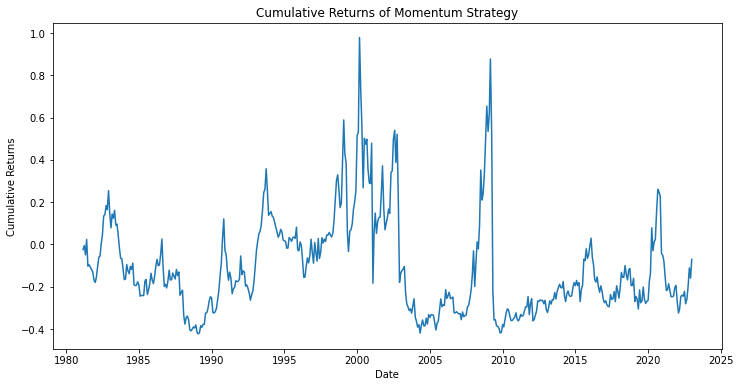

Mean Monthly Return: 0.03410961356459488
Standard Deviation of Monthly Returns: 0.2573666281881068
Sharpe Ratio: 0.13253316408864202


In [16]:
cumulative_returns = (R_momentum+1).cumprod()-1
mean_return = R_momentum.mean()*12
std_deviation = R_momentum.std()*np.sqrt(12)
sharpe_ratio = mean_return/std_deviation

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns of Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

# Print mean, standard deviation and sharpe ratio
print('Mean Monthly Return:', mean_return)
print('Standard Deviation of Monthly Returns:', std_deviation)
print('Sharpe Ratio:', sharpe_ratio)

Momentum Decile Weights (market-cap weighted)

In [17]:
import statsmodels.api as sm

Momentum Returns since 1980

In [11]:
#tmp = R_momentum['2008-01-01':].reset_index()
#print(tmp)
#tmp.columns = ['date', 'Mom_ret'] 


In [18]:
# (2)
regressors = (Industries + ['Rm'])
Rm['dateM'] = Rm['date'].astype('datetime64[M]')
df_tmp_regr = pd.merge(Rm, Industry_Returns, on='dateM')
df_tmp_regr[Industries] = df_tmp_regr[Industries] / 100.0
R_momentum.name = 'R_momentum'
df_regr = pd.merge(R_momentum, df_tmp_regr, on='date')
regression = sm.OLS(df_regr['R_momentum'], sm.add_constant(df_regr[regressors])).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:             R_momentum   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     11.57
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           6.54e-22
Time:                        16:57:57   Log-Likelihood:                 661.85
No. Observations:                 503   AIC:                            -1296.
Df Residuals:                     489   BIC:                            -1237.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.003      2.164      0.0

### Exercise 1.2
When we consider the observable market and the industry portfolio returns, we get a few significant exposures at the level of 5% p-value:

Chems, Durability, Energy, BusEq, Telecommunications, Money and the market returns are significant.

The p-value of the intercept is 3.1%, so it is significant too.

The $R^2$ is 0.235 and the adjusted $R^2$ is 0.215, so even though the intercept is very small, the risk-factors do not seem to explain the strategy performance that well. Also, the market return has a huge coefficient compared to the others.

## Observable Factors

In [13]:
# (3)
"""print(df_tmp_regr)
dict_betas = {}
for r in Industries:
    regr = sm.OLS(df_tmp_regr[r], sm.add_constant(df_tmp_regr['Rm'])).fit()
    alpha, beta = regr.params
    dict_betas[r] = beta
print(dict_betas)"""

"print(df_tmp_regr)\ndict_betas = {}\nfor r in Industries:\n    regr = sm.OLS(df_tmp_regr[r], sm.add_constant(df_tmp_regr['Rm'])).fit()\n    alpha, beta = regr.params\n    dict_betas[r] = beta\nprint(dict_betas)"

In [36]:
# Market betas
def ols_beta(df, xcols, ycol):
    p = sm.OLS(df[ycol], sm.add_constant(df[xcols])).fit().params
    return p.Rm_e
betas_mkt = data[['permno', 'Rn_e', 'Rm_e']].groupby('permno').apply(ols_beta, xcols='Rm_e', ycol='Rn_e')
betas_mkt.name = 'betas_mkt'
merge_beta = pd.merge(data,betas_mkt, on = 'permno')
data = merge_beta



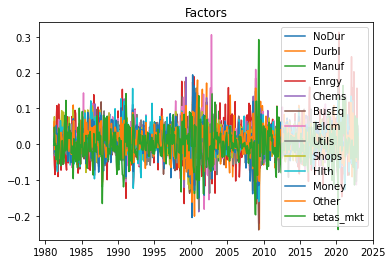

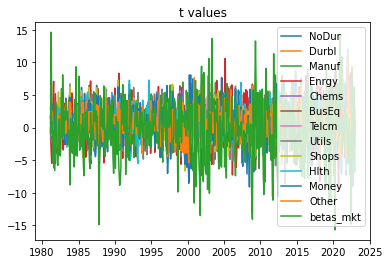

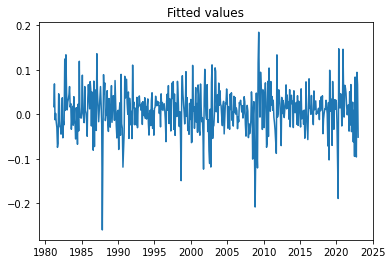

For NoDur, the average t-stat is 0.7962352852604986 and the average absolute value of the t-stat is 2.0494354149789897
For Durbl, the average t-stat is 0.4344221393003947 and the average absolute value of the t-stat is 1.4988035752439217
For Manuf, the average t-stat is 0.7185538217441491 and the average absolute value of the t-stat is 2.0228852451862616
For Enrgy, the average t-stat is 0.54836791998182 and the average absolute value of the t-stat is 2.518731239244501
For Chems, the average t-stat is 0.610028909503925 and the average absolute value of the t-stat is 1.6332680487396114
For BusEq, the average t-stat is 0.7933613828524542 and the average absolute value of the t-stat is 1.9866920953807083
For Telcm, the average t-stat is 0.509056132350582 and the average absolute value of the t-stat is 1.6570056728664788
For Utils, the average t-stat is 0.7178767231445833 and the average absolute value of the t-stat is 2.505417474504408
For Shops, the average t-stat is 0.8618056016554546 an

In [37]:
def ols_factors(df, xcols, ycol):
    p = sm.OLS(df[ycol], (df[xcols])).fit()
    return p.params
def ols_tvalues(df, xcols, ycol):
    p = sm.OLS(df[ycol], (df[xcols])).fit()
    return p.tvalues

def ols_fitted_vals(df, xcols, ycol):
    p = sm.OLS(df[ycol], (df[xcols])).fit()
    return p.fittedvalues    

temp_data = pd.DataFrame()
temp_data[Industries] = pd.get_dummies(data['FF_12'])
data[Industries] = temp_data[Industries]
factors = data.groupby('date').apply(ols_factors, ycol = 'Rn_e', xcols=Industries+['betas_mkt'])
#print(factors)
tvalues = data.groupby('date').apply(ols_tvalues, ycol = 'Rn_e', xcols=Industries+['betas_mkt'])
#print(tvalues)
fitted_vals = data.groupby('date').apply(ols_fitted_vals, ycol = 'Rn_e', xcols=Industries+['betas_mkt'])
fitted_vals = fitted_vals.groupby('date').mean()

for i in factors.columns:
    plt.plot(factors[i], label = i)

plt.legend()     
plt.title('Factors')    
plt.show()

for i in tvalues.columns:
    plt.plot(tvalues[i], label = i)
plt.legend()    
plt.title('t values')     
plt.show()


plt.plot(fitted_vals)
plt.title('Fitted values')
plt.show()


average_ts = [tvalues[i].mean() for i in tvalues.columns]


average_abs_ts = [abs(tvalues[i]).mean() for i in tvalues.columns]
#print(average_abs_ts)

for i in range(len(factors.columns)):
    print("For {}, the average t-stat is {} and the average absolute value of the t-stat is {}".format(tvalues.columns[i], average_ts[i], average_abs_ts[i]))



### Exercise 1.3
In order to decide which factors seem to be the most important ones, we use the average absolute value of the t-statistic. The larger the average, the more the factor tends to be in the critical area and thus be significant.

In practice, the most important factors seem to be BusEq, Money, Manuf, Enrgy and Shops.

Some t-statistics vary very widely, which could be due to tendencies in some industries. At different periods, industries may become more significant in the market, due to new innovations in the domain or macroeconomic factors and could therefore explain the stock returns better in different points in time.

## Unobservable Factors

In [16]:
# just run an ols for each ret for the market betas
#print(pd.get_dummies(data[['permno','FF_12']].unique()['FF_12']))
#tmp[Industries] = pd.get_dummies(tmp['FF_12'])
# then we run regression on tmp.groupby('date') but ols regr on Rn_e w mkt beta and industry betas

In [43]:
# construct a table that has both the momentum weights, the industry dummies and the market betas in it
Exposures = data[['date','w_momentum','betas_mkt'] + Industries]

# Then multiply the industry dummies and market beta with the portfolio weights 
Exposures[Industries] = Exposures[Industries]*Exposures['w_momentum'][:,np.newaxis]
Exposures['betas_mkt'] = Exposures['betas_mkt']*Exposures['w_momentum']

# Sum across all stocks to get the exposures 
Exposures = Exposures.groupby('date')[['betas_mkt'] + Industries].sum()

/var/folders/dp/6tl_3mwj73g1r7212tlzd9d00000gn/T/ipykernel_84833/1444710361.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Exposures[Industries] = Exposures[Industries]*Exposures['w_momentum'][:,np.newaxis]
/var/folders/dp/6tl_3mwj73g1r7212tlzd9d00000gn/T/ipykernel_84833/1444710361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Exposures[Industries] = Exposures[Industries]*Exposures['w_momentum'][:,np.newaxis]
/var/folders/dp/6tl_3mwj73g1r7212tlzd9d00000gn/T/ipykernel_84833/1444710361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

 ## Compute Factor Exposures from Weights

In [44]:
print(Exposures)

            betas_mkt     NoDur     Durbl     Manuf     Enrgy     Chems  \
date                                                                      
1981-02-27   0.000587  0.023775 -0.219729 -0.160857 -0.101877  0.020351   
1981-03-31  -0.081792  0.011060  0.001186 -0.068177 -0.164260  0.069932   
1981-04-30   1.251662  0.007894 -0.006449  0.169954 -0.168202 -0.048098   
1981-05-29   1.341337  0.057759  0.005054  0.159466 -0.308693 -0.098637   
1981-06-30   0.398174  0.063887  0.091383  0.095409 -0.418106 -0.095231   
...               ...       ...       ...       ...       ...       ...   
2022-08-31  -0.232450  0.029465  0.000000 -0.017939  0.232970  0.008961   
2022-09-30  -0.370963  0.031141 -0.011089 -0.016186  0.288308  0.019563   
2022-10-31  -0.493176  0.059601 -0.009773 -0.043527  0.280437  0.024452   
2022-11-30  -0.436337  0.048917 -0.007949  0.010996  0.290410 -0.005112   
2022-12-30  -0.339470  0.022064  0.000000  0.065120  0.290682  0.004714   

               BusEq    

In [45]:
# selection, COULD BE DONE WITH SMALLEST VARIANCE
for i in Exposures.columns:
    print("The absolute value of the mean of {} is: {}".format(i, abs(Exposures[i].mean())))

    


The absolute value of the mean of betas_mkt is: 0.01669151288897827
The absolute value of the mean of NoDur is: 0.021010325340715133
The absolute value of the mean of Durbl is: 0.0065347972582043105
The absolute value of the mean of Manuf is: 0.016248712643773127
The absolute value of the mean of Enrgy is: 0.03424978146650973
The absolute value of the mean of Chems is: 0.0012251138607031857
The absolute value of the mean of BusEq is: 0.05498878870860419
The absolute value of the mean of Telcm is: 0.018011775775594083
The absolute value of the mean of Utils is: 0.02022523763424342
The absolute value of the mean of Shops is: 0.012841675136752046
The absolute value of the mean of Hlth is: 0.003923667395498214
The absolute value of the mean of Money is: 0.002856810407369839
The absolute value of the mean of Other is: 0.001084714981990417


### Exercise 2.4
We decided to choose the absolute value of the mean as a metric, to take into account the consistency to the impact of the portfolio (either very positive ot very negative).
We therefore found that the largestabsolute values were for BusEq and for Energy, so we plotted the time series below.

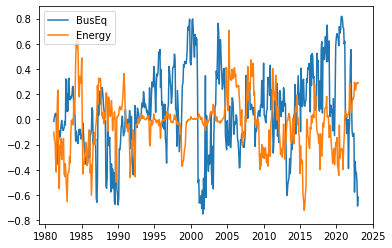

In [53]:
plt.plot(Exposures['BusEq'], label = 'BusEq')
plt.plot(Exposures['Enrgy'], label = 'Energy')
plt.legend()
plt.show()